# Flares detection from TEES Proxima Centauri data
We will use TLS to recover flares found in the Proxima Centauri
light curves from TESS. We will download the curves thanks to the
`lightkurve` package. Then, we will execute TLS with the known
stellar parameters from TESS ExoFOP. As TLS doesn't implement a flare
template, we will need to provide our custom implementation of
TransitTemplateGenerator:

In [1]:
from abc import ABC, abstractmethod

import batman
import numpy
from transitleastsquares import tls_constants
from transitleastsquares.grid import T14
from transitleastsquares.interpolation import interp1d
from transitleastsquares.template_generator.transit_template_generator import TransitTemplateGenerator
import matplotlib.pyplot as plt; plt.rcParams["figure.dpi"] = 150
import lightkurve as lk
import transitleastsquares as tls

class FlareTransitTemplateGenerator(TransitTemplateGenerator):
    def __init__(self):
        super().__init__()

    def reference_transit(self, period_grid, duration_grid, samples, per, rp, a, inc, ecc, w, u, limb_dark):
        f = numpy.ones(tls_constants.SUPERSAMPLE_SIZE)
        duration = 1  # transit duration in days. Increase for exotic cases
        t = numpy.linspace(-duration * 0.5, duration * 0.5, tls_constants.SUPERSAMPLE_SIZE)
        ma = batman.TransitParams()
        ma.t0 = 0  # time of inferior conjunction
        ma.per = per  # orbital period, use Earth as a reference
        ma.rp = rp  # planet radius (in units of stellar radii)
        ma.a = a  # semi-major axis (in units of stellar radii)
        ma.inc = inc  # orbital inclination (in degrees)
        ma.ecc = ecc  # eccentricity
        ma.w = w  # longitude of periastron (in degrees)
        ma.u = u  # limb darkening coefficients
        ma.limb_dark = limb_dark  # limb darkening model
        m = batman.TransitModel(ma, t)  # initializes model
        flux = m.light_curve(ma)  # calculates light curve
        # Determine start of transit (first value < 1)
        idx_first = numpy.argmax(flux < 1)
        intransit_time = t[idx_first: -idx_first + 1]
        flux = self.__reference_flare_transit(t, flux, per)
        # Determine start of transit (first value < 1)
        idx_first = numpy.argmax(flux > 1)
        intransit_flux = flux[idx_first: -idx_first + 1]
        # Downsample (bin) to target sample size
        x_new = numpy.linspace(t[idx_first], t[-idx_first - 1], samples, per)
        f = interp1d(x_new, intransit_time)
        downsampled_intransit_flux = f(intransit_flux)
        # Rescale to height [0..1..2]
        rescaled = 1 + 1 - (numpy.max(downsampled_intransit_flux) - downsampled_intransit_flux) / (
                numpy.max(downsampled_intransit_flux) - 1
        )
        return rescaled

    def fractional_transit(self,
                           period_grid,
                           duration_grid,
                           duration,
                           maxwidth,
                           depth,
                           samples,
                           per,
                           rp,
                           a,
                           inc,
                           ecc,
                           w,
                           u,
                           limb_dark,
                           cached_reference_transit=None,
                           ):
        """Returns a scaled reference transit with fractional width and depth"""

        if cached_reference_transit is None:
            reference_flux = self.reference_transit(
                period_grid=period_grid,
                duration_grid=duration_grid,
                samples=samples,
                per=per,
                rp=rp,
                a=a,
                inc=inc,
                ecc=ecc,
                w=w,
                u=u,
                limb_dark=limb_dark,
            )
        else:
            reference_flux = cached_reference_transit

        # Interpolate to shorter interval - new method without scipy
        reference_time = numpy.linspace(-0.5, 0.5, samples)
        occupied_samples = int((duration / maxwidth) * samples)
        x_new = numpy.linspace(-0.5, 0.5, occupied_samples)
        f = interp1d(x_new, reference_time)
        y_new = f(reference_flux)

        # Patch ends with ones ("1")
        missing_samples = samples - occupied_samples
        emtpy_segment = numpy.ones(int(missing_samples * 0.5))
        result = numpy.append(emtpy_segment, y_new)
        result = numpy.append(result, emtpy_segment)
        if numpy.size(result) < samples:  # If odd number of samples
            result = numpy.append(result, numpy.ones(1))

        # Depth rescaling
        result = 1 + ((result - 1) * depth)

        return result

    def get_cache(self, period_grid, durations, maxwidth_in_samples, per, rp, a, inc, ecc, w, u, limb_dark):
        """Fetches (size(durations)*size(depths)) light curves of length
            maxwidth_in_samples and returns these LCs in a 2D array, together with
            their metadata in a separate array."""

        print("Creating model cache for", str(len(durations)), "durations")
        lc_arr = []
        rows = numpy.size(durations)
        lc_cache_overview = numpy.zeros(
            rows,
            dtype=[("duration", "f8"), ("width_in_samples", "i8"), ("overshoot", "f8")],
        )
        cached_reference_transit = self.reference_transit(
            period_grid=period_grid,
            duration_grid=durations,
            samples=maxwidth_in_samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
        )

        row = 0
        for duration in durations:
            scaled_transit = self.fractional_transit(
                period_grid=period_grid,
                duration_grid=durations,
                duration=duration,
                maxwidth=numpy.max(durations),
                depth=tls_constants.SIGNAL_DEPTH,
                samples=maxwidth_in_samples,
                per=per,
                rp=rp,
                a=a,
                inc=inc,
                ecc=ecc,
                w=w,
                u=u,
                limb_dark=limb_dark,
                cached_reference_transit=cached_reference_transit,
            )
            lc_cache_overview["duration"][row] = duration
            used_samples = int((duration / numpy.max(durations)) * maxwidth_in_samples)
            lc_cache_overview["width_in_samples"][row] = used_samples
            full_values = numpy.where(
                scaled_transit > (1 + tls_constants.NUMERICAL_STABILITY_CUTOFF)
            )
            first_sample = numpy.min(full_values)
            last_sample = numpy.max(full_values) + 1
            signal = scaled_transit[first_sample:last_sample]
            lc_arr.append(signal)

            # Fraction of transit bottom and mean flux
            overshoot = numpy.max(signal) #/ numpy.mean(signal) * 1.

            # Later, we multiply the inverse fraction ==> convert to inverse percentage
            lc_cache_overview["overshoot"][row] = 1 / (2 - overshoot)
            row += +1

        lc_arr = numpy.array(lc_arr)
        return lc_cache_overview, lc_arr

    def duration_grid(self, periods, shortest, log_step=tls_constants.DURATION_GRID_STEP):
        duration_max = self.max_duration(min(periods), tls_constants.R_STAR_MAX, tls_constants.M_STAR_MAX)
        duration_min = self.min_duration(max(periods), tls_constants.R_STAR_MIN, tls_constants.M_STAR_MIN)
        durations = [duration_min]
        current_depth = duration_min
        while current_depth * log_step < duration_max:
            current_depth = current_depth * log_step
            durations.append(current_depth)
        durations.append(duration_max)  # Append endpoint. Not perfectly spaced.
        return durations

    def min_duration(self, period, R_star, M_star, periods=None):
        return T14(R_s=R_star, M_s=M_star, P=period, small=True)

    def max_duration(self, period, R_star, M_star, periods=None):
        return T14(R_s=R_star, M_s=M_star, P=period, small=False) * 5

    def __reference_flare_transit(self, t, flux, per):
        idx_first = numpy.argmax(flux < 1)
        t0 = 0.5 * per
        t1 = (t[idx_first] + 0.5) * per
        t01 = ((t0 + t1) / 2)
        t01 = ((t1 + t01) / 2)
        t4 = (t[-idx_first + 1] + 0.5) * per
        ingress_param = 0.075
        egress_param = 0.35
        amplitude = 1 - numpy.min(flux)
        y = numpy.ones(len(t))
        initialized = False
        for i in range(len(t)):
            time = (t[i] + 0.5) * per
            if flux[i] < 1 and time <= t01:
                y[i] = 1 + amplitude * numpy.exp(-((t01 - time) ** 2 / (2 * (ingress_param ** 2))))
                initialized = True
            elif time > t01 and flux[i] < 1:
                y[i] = 1 + amplitude * numpy.exp((t01 - time) / egress_param)
        return y


Now that we have created our FlareTransitTemplateGenerator, we will inject it
as an argument of the TLS `power` method:

In [2]:
generator = FlareTransitTemplateGenerator()
lcf = lk.search_lightcurvefile("TIC 388857263", mission="TESS", cadence="short").download_all()
power_args = {'transit_template': 'custom', 'period_min': 0.5, 'period_max': 33, 'n_transits_min': 2, 'T0_fit_margin': 0.05, 'oversampling_factor': 3, 'duration_grid_step': 1.1, 'u': (0.5221, 0.3406), 'R_star': 0.153719, 'R_star_min': 0.14889513999999998, 'R_star_max': 0.15854286, 'M_star': 0.125633, 'M_star_min': 0.10556309999999999, 'M_star_max': 0.1457029, 'transit_template_generator': generator}
pdcsap_flux = lcf.PDCSAP_FLUX.stitch().remove_nans()
model = tls.transitleastsquares(pdcsap_flux.time, pdcsap_flux.flux)
results = model.power(**power_args)

<ipython-input-1-604ef840f39b>:169: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lc_arr = numpy.array(lc_arr)
100%|██████████| 19749/19749 periods | 15:59<00:00
100%|██████████| 7153/7153 [00:06<00:00, 1094.07it/s]


Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 60 durations
Searching 35766 data points, 19749 periods from 0.5 to 27.428 days
Using all 8 CPU threads
Searching for best T0 for period 17.21981 days


The execution is finished, let's see the periodiogram:

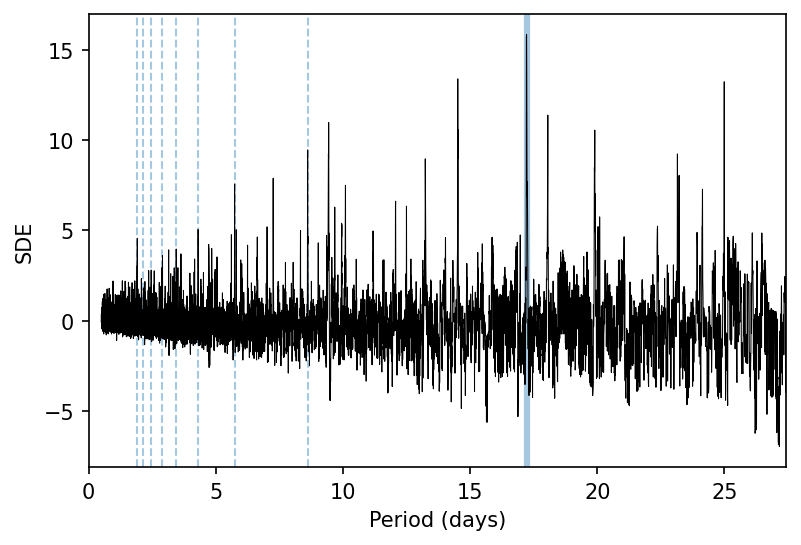

In [3]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

That's a strong signal. Let's look at the phase fold:

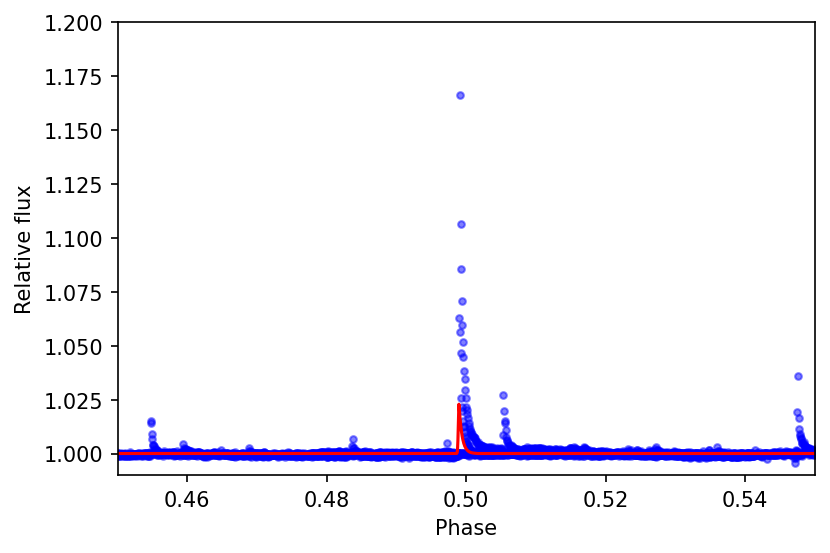

In [5]:
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.45, 0.55)
plt.ylim(0.99, 1.2)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

We can see that the fit is far to be perfect. This is
because the flares that we found were not exactly periodic and produce very
different flux increments, as can be apreciated from Vida et al. (2019).
However, this is a good example of the versatility that TLS provides now to
the scientist to search for whichever periodic shape that he/she would like.
